## Deep Q-Network: Dueling DQN

给模型参数增加随机性

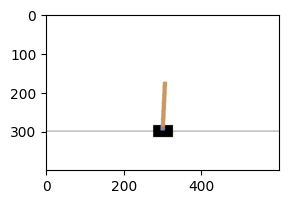

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    over = terminated or truncated

    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
        over = True
    
    #没坚持到最后,扣分
    if over and self.step_n < 200:
        reward = -1000

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()

In [4]:
import torch
	
"code changed this cell"
#定义模型,评估状态下每个动作的价值
class Model(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc = torch.nn.Sequential(
			torch.nn.Linear(4, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 64),
			torch.nn.ReLU(),
		)
    
    # 输出层参数的均值和标准差
    self.weight_mean = torch.nn.Parameter(torch.randn(64, 2))
    self.weight_std = torch.nn.Parameter(torch.randn(64, 2))
    
    self.bias_mean = torch.nn.Parameter(torch.randn(2))
    self.bias_std = torch.nn.Parameter(torch.randn(2))
    
  def forward(self, state):
    state = self.fc(state)
    
    # 正态分布投影
    weight = self.weight_mean + torch.randn(64, 2) * self.weight_std
    bias = self.bias_mean + torch.randn(2) * self.bias_std
    
    # 运行模式下不需要随机性
    if not self.training:
      weight = self.weight_mean
      bias = self.bias_mean
      
    # 计算输出
    return state.matmul(weight) + bias

model = Model()
model_delay = Model()

#复制参数
model_delay.load_state_dict(model.state_dict())

model(torch.randn(5, 4)).shape


torch.Size([5, 2])

In [5]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
  data = []
  reward_sum = 0

  state = env.reset()
  over = False
  while not over:
    # 由于模型的随机性，这里不需要随机动作了
    action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
    
    # if random.random() < 0.1:
    #   action = env.action_space.sample() code changed

    next_state, reward, over = env.step(action)

    data.append((state, action, reward, next_state, over))
    reward_sum += reward

    state = next_state

    if show:
      display.clear_output(wait=True)
      env.show()

  return data, reward_sum


play()[-1]

-989.0

In [6]:
#数据池
class Pool:

  def __init__(self):
    self.pool = []

  def __len__(self):
    return len(self.pool)

  def __getitem__(self, i):
    return self.pool[i]

  #更新动作池
  def update(self):
    #每次更新不少于N条新数据
    old_len = len(self.pool)
    while len(pool) - old_len < 200:
        self.pool.extend(play()[0])

    #只保留最新的N条数据
    self.pool = self.pool[-2_0000:]

  #获取一批数据样本
  def sample(self):
    data = random.sample(self.pool, 64)

    state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
    action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
    reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
    next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
    over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

    return state, action, reward, next_state, over


pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0]

C:\Users\fanyu\AppData\Local\Temp\ipykernel_11872\732246400.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)


(206,
 (array([-0.0091998 ,  0.0020935 ,  0.01819116,  0.00248633], dtype=float32),
  0,
  1.0,
  array([-0.00915793, -0.19328454,  0.01824089,  0.30085284], dtype=float32),
  False))

In [9]:
#训练
def train():
  model.train()
  model_delay.eval()  # code changed here
  optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
  loss_fn = torch.nn.MSELoss()

  #共更新N轮数据
  for epoch in range(1000):
    pool.update()

    #每次更新数据后,训练N次
    for i in range(200):

      #采样N条数据
      state, action, reward, next_state, over = pool.sample()

      #计算value
      value = model(state).gather(dim=1, index=action)

      #计算target
      with torch.no_grad():
        target = model_delay(next_state)
      target = target.max(dim=1)[0].reshape(-1, 1)
      target = target * 0.99 * (1 - over) + reward

      loss = loss_fn(value, target)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    #复制参数
    if (epoch + 1) % 5 == 0:
      model_delay.load_state_dict(model.state_dict())

    if epoch % 100 == 0:
      # code changed here"
      model.eval()
      test_result = sum([play()[-1] for _ in range(20)]) / 20
      model.train()
      print(epoch, len(pool), test_result)
      
      weight = model.weight_mean + 1 * model.weight_std
      bias = model.bias_mean + 1 * model.bias_std
      print("weight=",
            weight.mean().item(),
            weight.std().item(), 'bias=', bias.tolist())
			# code chang end "

train()

0 20000 -261.4
weight= 0.08487246930599213 2.2399160861968994 bias= [0.8240109086036682, -2.496382713317871]
100 20000 -511.65
weight= 0.09852884709835052 2.2896430492401123 bias= [0.829233705997467, -2.4733049869537354]
200 20000 99.1
weight= 0.07409109175205231 2.33424711227417 bias= [0.8488125205039978, -2.4004099369049072]
300 20000 200.0
weight= 0.056328870356082916 2.3695991039276123 bias= [0.8497005701065063, -2.3592135906219482]
400 20000 200.0
weight= 0.08827070891857147 2.3714795112609863 bias= [0.8442493081092834, -2.3491461277008057]
500 20000 200.0
weight= 0.11783010512590408 2.3518106937408447 bias= [0.826187252998352, -2.3343119621276855]
600 20000 200.0
weight= 0.1335139125585556 2.3400332927703857 bias= [0.8299434781074524, -2.3179783821105957]
700 20000 200.0
weight= 0.14853978157043457 2.3380069732666016 bias= [0.8218559622764587, -2.3238685131073]
800 20000 200.0
weight= 0.15474089980125427 2.3362767696380615 bias= [0.8242064714431763, -2.3087143898010254]
900 20000

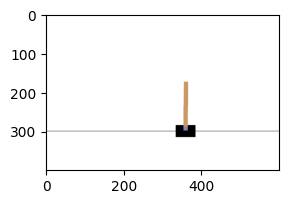

200.0

In [10]:
play(True)[-1]